In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.1.0


### 과대적합과 과소적합

과대적합 : 검증 세트에서 모델 성능이 최고점에 도달한 다음 감소하는 경우 >> 모델이 훈련 세트에 과대적합한 것  
우리가 진짜 원하는 것은 테스트 세트에 잘 일반화 되는 모델임.

과소적합 : 모델의 성능이 향상될 여지가 아직 있을 때 일어남.  
모델이 너무 단순하거나, 규제가 너무 많거나, 그냥 단순히 충분히 오래 훈련하지 않는 경우.  
즉 네트워크가 훈련 세트에서 적절한 패턴을 학습하지 못했다는 뜻.

과대적합을 막는 가장 좋은 방법은 더 많은 훈련 데이터를 사용하는 것.  
데이터를 더 준비할 수 없을 때 규제와 드롭아웃을 사용


#### IMDB 데이터셋 다운로드
이전 노트북에서처럼 임베딩을 사용하지 않고 여기에서는 문장을 멀티-핫 인코딩으로 변환함.  
이 모델은 훈련 세트에서 빠르게 과대적합될 것임. 

멀티-핫 인코딩은 정수 시퀀스를 0과1로 이루어진 벡터로 변환함. 정확하게 말하면 시퀀스 [3,5]를 인덱스 3과 5만 1이고 나머지는 모두 0인 10000 차원 백터로 변환한다는 의미임.

In [2]:
NUM_WORDS = 1000
(train_data , train_labels) , (test_data, test_labels) = keras.datasets.imdb.load_data(num_words= NUM_WORDS)

In [3]:
def multi_hot_sequences(sequences, dimension):
    # 0으로 채워진 (len(sequences), dimension) 크기의 행렬을 만듬
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0 # results[i]의 특성 인덱스만 1로 설정
    return results

train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

만들어진 멀티-핫 벡터 중 하나를 살펴 보자. 단어 인덱스는 빈도 순으로 정렬되어 있음. 그래프에서 볼 수 있듯이 인덱스 0에 가까울수록 1이 많이 등장함.

In [4]:
import matplotlib.pyplot as plt

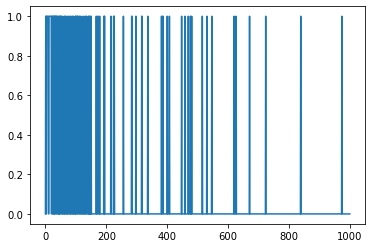

In [5]:
plt.plot(train_data[0])

#### 과대적합 예제

과대적합을 막는 가장 간단한 방법은 모델의 규모를 축소하는 것. 즉, 모델이 있는 학습 가능한 파라미터의 수를 줄임.  
딥러닝에서는 모델의 학습 가능한 파라미터의 수를 종종 모델의 '용량'이라고 말함. 직관적으로 생각해보면 많은 파라미터를 가진 모델이 더 많은 '기억 용량'을 가짐.  
이런 모델은 훈련 샘플과 타깃 사이를 일반화 능력이 없는 딕셔너리와 같은 매핑으로 완벽하게 학슴할 수 있음. 하지만 이전에는 본 적 없는 데이터에서 예측을 할 땐 쓸모가 없을 것임.

항상 기억해야할 점 : 딥러닝 모델이 훈련 세트에서는 학습이 잘 되는 경향이 있지만 진짜 잘 해결할 문제는 학습이 아니라 일반화라는 것임
    
반면에 네트워크의 기억 용량이 부족하다면 이런 매핑을 쉽게 학습할 수 없을 것. 손실을 최소화하기 위해서는 예측 성능이 더 많은 압축된 표현을 학습해야 함. 또한 너무 작은 모델을  만들면 훈련 데이터를 학습하기 어려울 것임. '너무 많은 용량'과 충분하지 않은 용량' 사이의 균형을 잡아야 함.

안타깝게도, 어떤 모델의 적절한 크기나 구조를 결정하는 마법같은 공식은 X. 여러 가지 다른 구조를 사용해 실험을 해볼 것.

알맞은 모델의 크기를 찾으려면 비교적 적은 수의 층과 파라미터로 시작해서 검증 손실이 감소할 때까지 새로운 층을 추가하거나 층의 크기를 늘리는 것이 좋음.

영화 리뷰 분류 네트워크를 사용해 이를 실험해 보자.

Dense 층만 사용하는 간단한 기준 모델을 만들고 작은 규모의 버전과 큰 버전의 모델을 만들어 비교하겠음.

#### 기준 모델 만들기


In [6]:
baseline_model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape= (NUM_WORDS,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(optimizer ='adam',
                      loss = 'binary_crossentropy',
                      metrics =['accuracy', 'binary_crossentropy'])

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                16016     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 16,305
Trainable params: 16,305
Non-trainable params: 0
_________________________________________________________________


In [7]:
baseline_history = baseline_model.fit(train_data,
                                     train_labels,
                                     epochs=20,
                                     batch_size= 512,
                                     validation_data = (test_data,test_labels),
                                     verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 1s - loss: 0.6010 - accuracy: 0.6946 - binary_crossentropy: 0.6010 - val_loss: 0.4587 - val_accuracy: 0.8095 - val_binary_crossentropy: 0.4587
Epoch 2/20
25000/25000 - 0s - loss: 0.3764 - accuracy: 0.8437 - binary_crossentropy: 0.3764 - val_loss: 0.3441 - val_accuracy: 0.8554 - val_binary_crossentropy: 0.3441
Epoch 3/20
25000/25000 - 0s - loss: 0.3203 - accuracy: 0.8671 - binary_crossentropy: 0.3203 - val_loss: 0.3294 - val_accuracy: 0.8603 - val_binary_crossentropy: 0.3294
Epoch 4/20
25000/25000 - 0s - loss: 0.3063 - accuracy: 0.8742 - binary_crossentropy: 0.3063 - val_loss: 0.3278 - val_accuracy: 0.8610 - val_binary_crossentropy: 0.3278
Epoch 5/20
25000/25000 - 0s - loss: 0.2994 - accuracy: 0.8770 - binary_crossentropy: 0.2994 - val_loss: 0.3289 - val_accuracy: 0.8601 - val_binary_crossentropy: 0.3289
Epoch 6/20
25000/25000 - 0s - loss: 0.2952 - accuracy: 0.8783 - binary_crossentropy: 0.2952 - val_loss: 0.3329

#### 작은 모델 만들기
앞서 만든 기준 모델과 비교하기 위해 적은 수의 은닉 유닛을 가진 모델을 만들어 보자.


In [8]:
smaller_model = keras.Sequential([
    keras.layers.Dense(4, activation ='relu', input_shape =(NUM_WORDS,)),
    keras.layers.Dense(4, activation ='relu'),
    keras.layers.Dense(1, activation ='sigmoid')
    
])

smaller_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics =['accuracy', 'binary_crossentropy'])

smaller_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 4004      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 4,029
Trainable params: 4,029
Non-trainable params: 0
_________________________________________________________________


같은 데이터를 사용해 이 모델을 훈련함.

In [9]:
smaller_histroy = smaller_model.fit(train_data,
                                   train_labels,
                                   epochs= 20,
                                   batch_size =512,
                                   validation_data = (test_data,test_labels),
                                   verbose =2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 1s - loss: 0.6732 - accuracy: 0.5889 - binary_crossentropy: 0.6732 - val_loss: 0.6378 - val_accuracy: 0.6671 - val_binary_crossentropy: 0.6378
Epoch 2/20
25000/25000 - 0s - loss: 0.5941 - accuracy: 0.7268 - binary_crossentropy: 0.5941 - val_loss: 0.5521 - val_accuracy: 0.7785 - val_binary_crossentropy: 0.5521
Epoch 3/20
25000/25000 - 0s - loss: 0.5058 - accuracy: 0.8142 - binary_crossentropy: 0.5058 - val_loss: 0.4668 - val_accuracy: 0.8384 - val_binary_crossentropy: 0.4668
Epoch 4/20
25000/25000 - 0s - loss: 0.4150 - accuracy: 0.8512 - binary_crossentropy: 0.4150 - val_loss: 0.3861 - val_accuracy: 0.8506 - val_binary_crossentropy: 0.3861
Epoch 5/20
25000/25000 - 0s - loss: 0.3493 - accuracy: 0.8636 - binary_crossentropy: 0.3493 - val_loss: 0.3480 - val_accuracy: 0.8576 - val_binary_crossentropy: 0.3480
Epoch 6/20
25000/25000 - 0s - loss: 0.3221 - accuracy: 0.8698 - binary_crossentropy: 0.3221 - val_loss: 0.3357

#### 큰 모델 만들기
아주 큰 모델을 만들어 얼마나 빠르게 과대적합이 시작되는지 알아 볼 수 있음. 이 문제에 필요한 것보다 훨씬 더 큰 용량을 가진 네트워크를 추가해서 비교해 보자.

In [10]:
bigger_model = keras.models.Sequential([
    keras.layers.Dense(512, activation ='relu', input_shape = (NUM_WORDS,)),
    keras.layers.Dense(512, activation ='relu'),
    keras.layers.Dense(1, activation= 'sigmoid')])

bigger_model.compile(optimizer ='adam',
                    loss='binary_crossentropy',
                    metrics = ['accuracy', 'binary_crossentropy'])

bigger_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               512512    
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 775,681
Trainable params: 775,681
Non-trainable params: 0
_________________________________________________________________


역시 같은 데이터를 사용해 모델을 훈련함

In [11]:
bigger_history = bigger_model.fit(train_data, train_labels,
                                 epochs=20,
                                 batch_size=512,
                                 validation_data = (test_data, test_labels),
                                 verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 2s - loss: 0.4244 - accuracy: 0.8033 - binary_crossentropy: 0.4244 - val_loss: 0.3299 - val_accuracy: 0.8584 - val_binary_crossentropy: 0.3299
Epoch 2/20
25000/25000 - 1s - loss: 0.2970 - accuracy: 0.8768 - binary_crossentropy: 0.2970 - val_loss: 0.3508 - val_accuracy: 0.8482 - val_binary_crossentropy: 0.3508
Epoch 3/20
25000/25000 - 1s - loss: 0.2264 - accuracy: 0.9099 - binary_crossentropy: 0.2264 - val_loss: 0.3423 - val_accuracy: 0.8564 - val_binary_crossentropy: 0.3423
Epoch 4/20
25000/25000 - 1s - loss: 0.1137 - accuracy: 0.9646 - binary_crossentropy: 0.1137 - val_loss: 0.4386 - val_accuracy: 0.8441 - val_binary_crossentropy: 0.4386
Epoch 5/20
25000/25000 - 1s - loss: 0.0268 - accuracy: 0.9957 - binary_crossentropy: 0.0268 - val_loss: 0.5287 - val_accuracy: 0.8470 - val_binary_crossentropy: 0.5287
Epoch 6/20
25000/25000 - 1s - loss: 0.0053 - accuracy: 0.9998 - binary_crossentropy: 0.0053 - val_loss: 0.5992

#### 훈련 손실과 검증 손실 그래프 그리기
실선은 훈련 손실이고 점선은 검증 손실임. 여기서는 작은 네트워크가 기준 모델보다 저 늦게 과대적합이 시작됨. 또한 과대적합이 시작되고 훨씬 천천히 성능이 감소함.

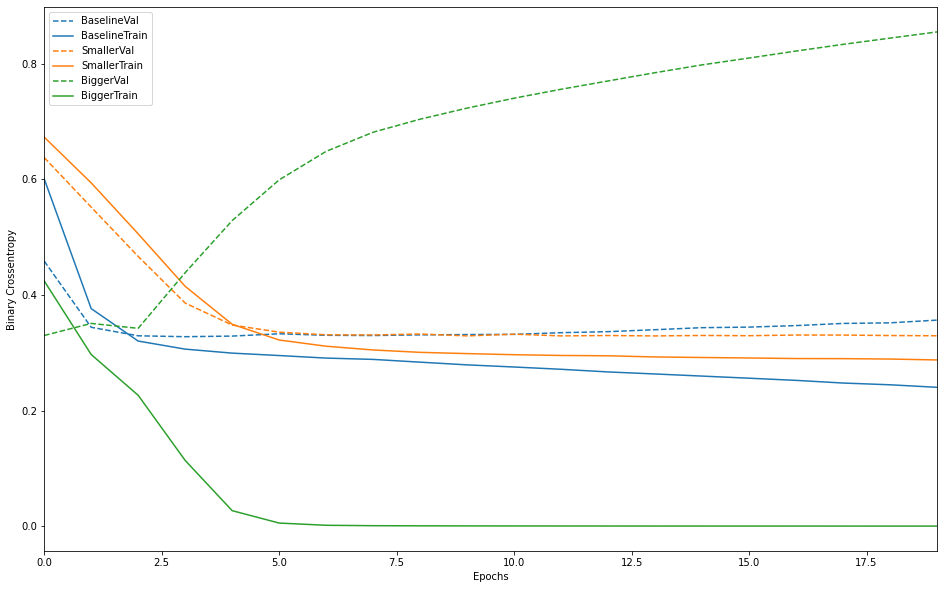

In [12]:
def plot_history(histories , key = 'binary_crossentropy'):
    plt.figure(figsize=(16,10))
    
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                      '--', label=name.title()+'Val')
        plt.plot(history.epoch, history.history[key], color = val[0].get_color(),
                label=name.title()+'Train')
        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_',' ').title())
        plt.legend()
        plt.xlim([0,max(history.epoch)])
        
plot_history([('baseline', baseline_history),
                 ('smaller', smaller_histroy),
                 ('bigger', bigger_history)])

큰 네트워크는 거의 바로 첫 번째 에포크 이후에 과대적합이 시작되고 훨씬 더 심각하게 과대적합됨. 네트워크의 용량이 많을수록 훈련 세트를 더 빠르게 모델링할 수 있음.  
하지만 더 쉽게 과대적함됨.

### 과대적합을 방지하기 위한 전략
#### 가중치를 규제하기
오캄의 면돌날 이론 : 어떤 것을 설명하는 두 가지 방법이 있다면 더 정확한 설명은 최소한의 가정이 필요한 가장 "간단한" 설명일 것임. 이는 신경망으로 학습되는 모델에도 적용됨. 훈련 데이터와 네트워크 구조가 주어졌을 때 이 데이터를 설명할 수 있는 가중치 조합(즉, 가능한 모델)은 많음. 간단한 모델은 복잡한 것보다 과대적합되는 경향이 작을 것임.

여기서는 "간단한 모델"은 모델 파라미터의 분포를 봤을 때 엔트로피가 작은 모델임. 따라서 과대적합을 완화시키는 일반적인 방법은 가중치가 작은 값을 가지도록 네트워크의 복잡도에 제약을 가하는 것임. 이는 가중치 값의 분포를 좀 더 균일하게 만들어 줌. 이를 "가중치 규제"라고 부름. 네트워크의 손실 함수에 큰 가중치에 해당하는 비용을 추가함. 이 비용은 두 가지 형태가 있음.
- L1 규제는 가중치의 절댓값에 비례하는 비용이 추가됨.(즉, 가중치의 'L1 norm'을 추가함).
- L2 규제는 가중치의 제곱에 비례하는 비용이 추가됨(즉, 가중치의 "L2 norm"의 제곱을 추가함.). 신경망에서는 L2 규제를 가중치 감쇠라고도 부름. 이름이 다르지만 혼돈하지 말자. 가중치 감쇠는 수학적으로 L2규제와 동일함.

L1 규제는 일부 가중치 파라미터를 0으로 만듬. L2 규제는 가중치 파라미터를 제한하지만 완전히 0으로 만들지 않습니다. 이것이 L2 규제를 더 많이 사용하느 이유 중 하나임.

tf.keras 에서는 가중치 규제 객체를 층의 키워드 매개변수에 전달하여 가중치에 규제를 추가함. L2 가중치 규제를 추가함.

In [13]:
l2_model = keras.models.Sequential([
    keras.layers.Dense(16, kernel_regularizer=  keras.regularizers.l2(0.001),
                      activation= 'relu', input_shape = (NUM_WORDS,)),
    keras.layers.Dense(16,kernel_regularizer= keras.regularizers.l2(0.001),
                     activation ='relu'),
    keras.layers.Dense(1,activation='sigmoid')
    
])

l2_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics= ['accuracy', 'binary_crossentropy'])
l2_model_history = l2_model.fit(train_data, train_labels,
                               epochs=20, batch_size= 512,
                               validation_data= (test_data, test_labels),
                               verbose =2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 1s - loss: 0.6331 - accuracy: 0.6892 - binary_crossentropy: 0.5881 - val_loss: 0.4813 - val_accuracy: 0.8172 - val_binary_crossentropy: 0.4373
Epoch 2/20
25000/25000 - 0s - loss: 0.4177 - accuracy: 0.8442 - binary_crossentropy: 0.3735 - val_loss: 0.3976 - val_accuracy: 0.8505 - val_binary_crossentropy: 0.3537
Epoch 3/20
25000/25000 - 0s - loss: 0.3665 - accuracy: 0.8669 - binary_crossentropy: 0.3234 - val_loss: 0.3845 - val_accuracy: 0.8560 - val_binary_crossentropy: 0.3422
Epoch 4/20
25000/25000 - 0s - loss: 0.3516 - accuracy: 0.8712 - binary_crossentropy: 0.3103 - val_loss: 0.3693 - val_accuracy: 0.8613 - val_binary_crossentropy: 0.3289
Epoch 5/20
25000/25000 - 0s - loss: 0.3448 - accuracy: 0.8743 - binary_crossentropy: 0.3052 - val_loss: 0.3661 - val_accuracy: 0.8618 - val_binary_crossentropy: 0.3275
Epoch 6/20
25000/25000 - 0s - loss: 0.3393 - accuracy: 0.8763 - binary_crossentropy: 0.3013 - val_loss: 0.3660

l2(0.001) 는 네트워크의 전체 손실에 층에 있는 가중치 행렬의 모든 값이 0.001 * weight_coefficient_value**2 만큼 더해진다는 의미임. 이런 패널티는 훈련할 때만 추가됨. 따라서 테스트 단계보다 훈련 단게에서 네트워크 손실이 훨씬 더 클 것임.

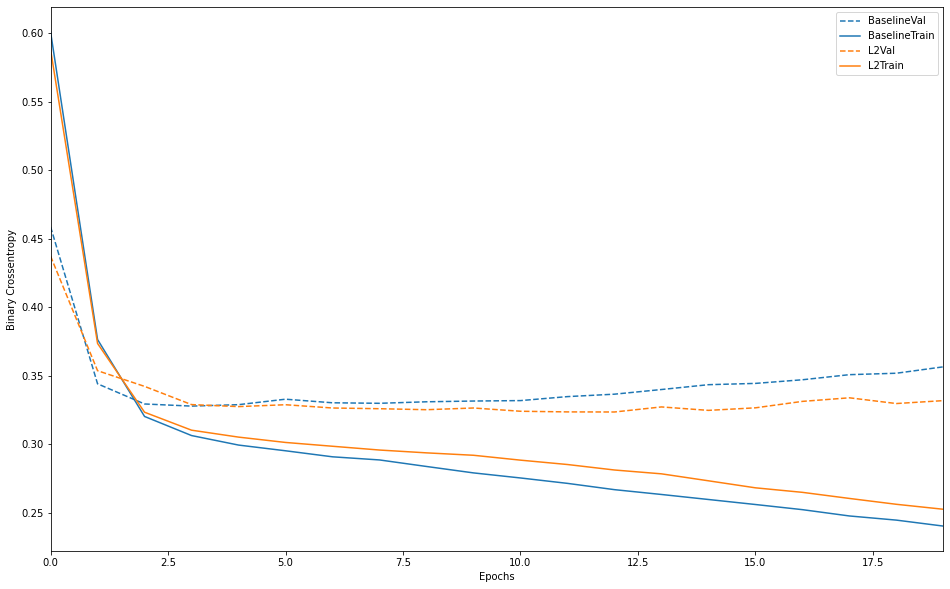

In [14]:
plot_history([('baseline', baseline_history),('l2',l2_model_history)])

결과에서 보듯이 모델 파라미터의 개수는 같지만 L2 규제를 적용한 모델이 기본 모델보다 과대적합에 훨씬 잘 견디고 있음.

#### 드롭아웃 추가하기

드롭아웃은 신경망에서 가장 효과적이고 널리 사용하는 규제 기법 중 하나임.  
드롭아웃을 층에 적용하면 훈련하는 동안 층의 출력 특성을 랜덤하게 끕니다. 훈련하는 동안 어떤 입력 샘플에 대해 [0.2, 0.5, 1.3, 0.8, 1.1] 벡터를 출력하는 층이 있다고 가정해 보자. 드롭아웃을 적용하면 이 벡터에서 몇 개의 원소가 랜덤하게 0이 됨.예를 들면 [0, 0.5, 1.3, 0, 1.1]가 됨. "드롭아웃 비율"은 0이 되는 특성의 비율임. 보통 0.2에서 0.5사이를 사용함. 테스트 단게에서는 어떤 유닛도 드롭아웃하지 않음. 훈련 단계보다 더 많은 유닛이 활성화되기 때문에 균형을 맞추기 위해 층의 출력 값을 드롭아웃 비율만큼 줄임.

tf.keras 에서는 Dropout 층을 이용해 네트워크에 드롭아웃을 추가할 수 있음. 이 층은 바로 이전 층의 출력에 드롭아웃으 적용함.

IMDB 네트워크에 두 개의 Dropout 층을 추가하여 과대적합이 얼마나 감소하는지 알아 보자.

In [16]:
dpt_model = keras.models.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

dpt_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics = ['accuracy', 'binary_crossentropy'])

dpt_model_history = dpt_model.fit(train_data, train_labels,
                                 epochs=20 ,
                                 batch_size=512,
                                 validation_data = (test_data, test_labels),
                                 verbose =2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 1s - loss: 0.6791 - accuracy: 0.5678 - binary_crossentropy: 0.6791 - val_loss: 0.6145 - val_accuracy: 0.7397 - val_binary_crossentropy: 0.6145
Epoch 2/20
25000/25000 - 0s - loss: 0.5906 - accuracy: 0.6885 - binary_crossentropy: 0.5906 - val_loss: 0.4778 - val_accuracy: 0.8215 - val_binary_crossentropy: 0.4778
Epoch 3/20
25000/25000 - 0s - loss: 0.5018 - accuracy: 0.7666 - binary_crossentropy: 0.5018 - val_loss: 0.3933 - val_accuracy: 0.8450 - val_binary_crossentropy: 0.3933
Epoch 4/20
25000/25000 - 0s - loss: 0.4460 - accuracy: 0.8059 - binary_crossentropy: 0.4460 - val_loss: 0.3569 - val_accuracy: 0.8533 - val_binary_crossentropy: 0.3569
Epoch 5/20
25000/25000 - 0s - loss: 0.4161 - accuracy: 0.8264 - binary_crossentropy: 0.4161 - val_loss: 0.3417 - val_accuracy: 0.8570 - val_binary_crossentropy: 0.3417
Epoch 6/20
25000/25000 - 0s - loss: 0.3906 - accuracy: 0.8391 - binary_crossentropy: 0.3906 - val_loss: 0.3370

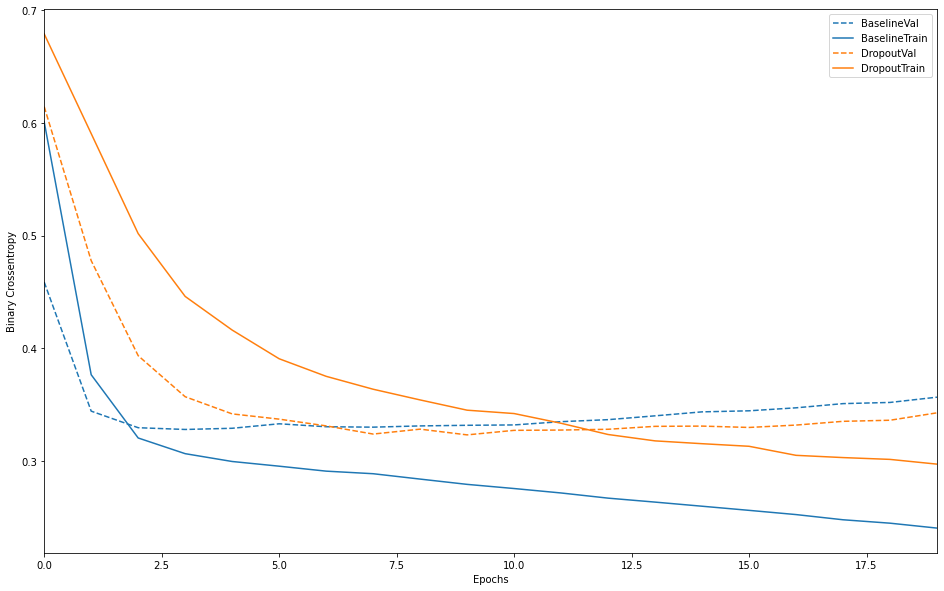

In [17]:
plot_history([('baseline', baseline_history), 
             ('dropout', dpt_model_history)])

드롭아웃을 추가하니 기준 모델보다 확실히 향상됨. 

정리하면 신경망에서 과대적합을 방지하기 위해 가장 널리 사용하는 방버은 다음과 같음
- 더 많은 훈련 데이터를 모음
- 네트워크의 용량을 줄임
- 가중치 규제를 추가함
- 드롭아웃을 추가함 

이 문서에서는 다루지 않은 중요한 방법 두가지는 데이터 증식과 배치 정규화임.

In [18]:
#저작권
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.